In [1]:
import xarray as xr
import zarr
import glob
import pandas as pd
import numpy as np
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import ipywidgets as widgets
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')


Bad key text.latex.preview in file /home/peter/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/peter/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/peter/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality p

Every year around February thousands of turtle hatchlings are born on the beaches of Northern KwaZulu-Natal. From here they enter the Indian Ocean and begin their journey south hitching a ride on the warm Agulhas Current. Little is known about the fate of these hatchlings save for the fact that only very few will make it to adulthood. One of the major obstacles these hatchlings face is being swept out of the warm agulhas current and into colder waters were they become hypothermic. Some of these hatchlings become stranded on beaches of the Western Cape where volunteers endevour to save them. The lucky few hatchlings which are found alive are brought to the Two Oceans Aquarium in Cape Town where they are rehabilitatad before they are strong enough to be released back into the wild. Monitoring such a vast coastline is however a mamoth task. Currently the program relies upon citizen reports from people happen across the stranded hatchlings, however recently the turtle team has had some succcess monitoring weather patterns and disspatching teams to turtle stranding hotspots when they think a stranding event may take place. At present this is however a very informal process and is believed could be improved upon by making better tools available to the turtle rescue teams. 

In [2]:
stranding_data = pd.read_csv('2015_2021_hatchling_stranding_summary.csv', names = ['Id', 'Date','Species','Location'])

In [3]:
display(stranding_data.Species.value_counts() )

Caretta caretta         622
Dermochelys coriacea      6
Name: Species, dtype: int64

I will only consider the Caretta Caretta species in a bid to reduce noise as this is by far the dominant species

In [4]:
stranding_data = stranding_data.loc[stranding_data['Species'] == 'Caretta caretta']

In [5]:
#correct a few spelling errors
stranding_data.loc[stranding_data['Location'] == 'Mosselbay', 'Location'] = 'Mossel Bay'
stranding_data.loc[stranding_data['Location'] == 'Witsand', 'Location'] = 'Witsands'
stranding_data.loc[stranding_data['Location'] == 'Tenikwa PLETT', 'Location'] = 'Plettenberg Bay'
stranding_data.loc[stranding_data['Location'] == 'Tenikwa', 'Location'] = 'Plettenberg Bay'

First lets consider the locations of the strandings 

In [6]:
display(stranding_data.Location.value_counts() )

Struisbaai             329
Mossel Bay              45
Muizenberg              38
Witsands                35
Plettenberg Bay         22
Arniston                22
Hermanus                18
Gaansbaai               12
Sedgefield              11
Strandfontein            8
Scarborough              8
Kommetjie                7
Fish Hoek                6
Knysna                   5
Stilbaai                 5
Plett                    4
Cape Agulhas             3
Stillbaai                3
Vleesbaai                3
Glencairn                3
Simons Town              2
Wilderness               2
Grotto Beach             2
Buffels Bay              2
Unknown                  1
Table Bay                1
Gordans Bay              1
Aghulas                  1
Milnerton                1
Blouberg                 1
Camps Bay                1
Blombos                  1
Smitswinkel              1
Kleinmond                1
Clovelly                 1
Sandy Bay                1
St Francis               1
K

Struisbaai is by far the most common stranding location presumably because of it's southerly geographic position, below the locations with more than 10 strandings recoded have been plotted

In [7]:
stranding_data = stranding_data.groupby('Location').filter(lambda x: len(x) >= 10) #consider only loactions with greater then 10 strandings

In [8]:
# Manually set locations for most common strandings
latlong_dict = {}
latlong_dict['Struisbaai'] = [-34.80, 20.10]
latlong_dict['Mossel Bay'] = [-34.15, 22.20]
latlong_dict['Muizenberg'] = [-34.11, 18.52]
latlong_dict['Witsands'] = [-34.41, 20.92]
latlong_dict['Arniston'] = [-34.67, 20.27]
latlong_dict['Plettenberg Bay'] = [-34.07, 23.44]
latlong_dict['Hermanus'] = [-34.44, 19.25]
latlong_dict['Sedgefield'] = [-34.10, 22.78]
latlong_dict['Gaansbaai'] = [-34.64, 19.35]

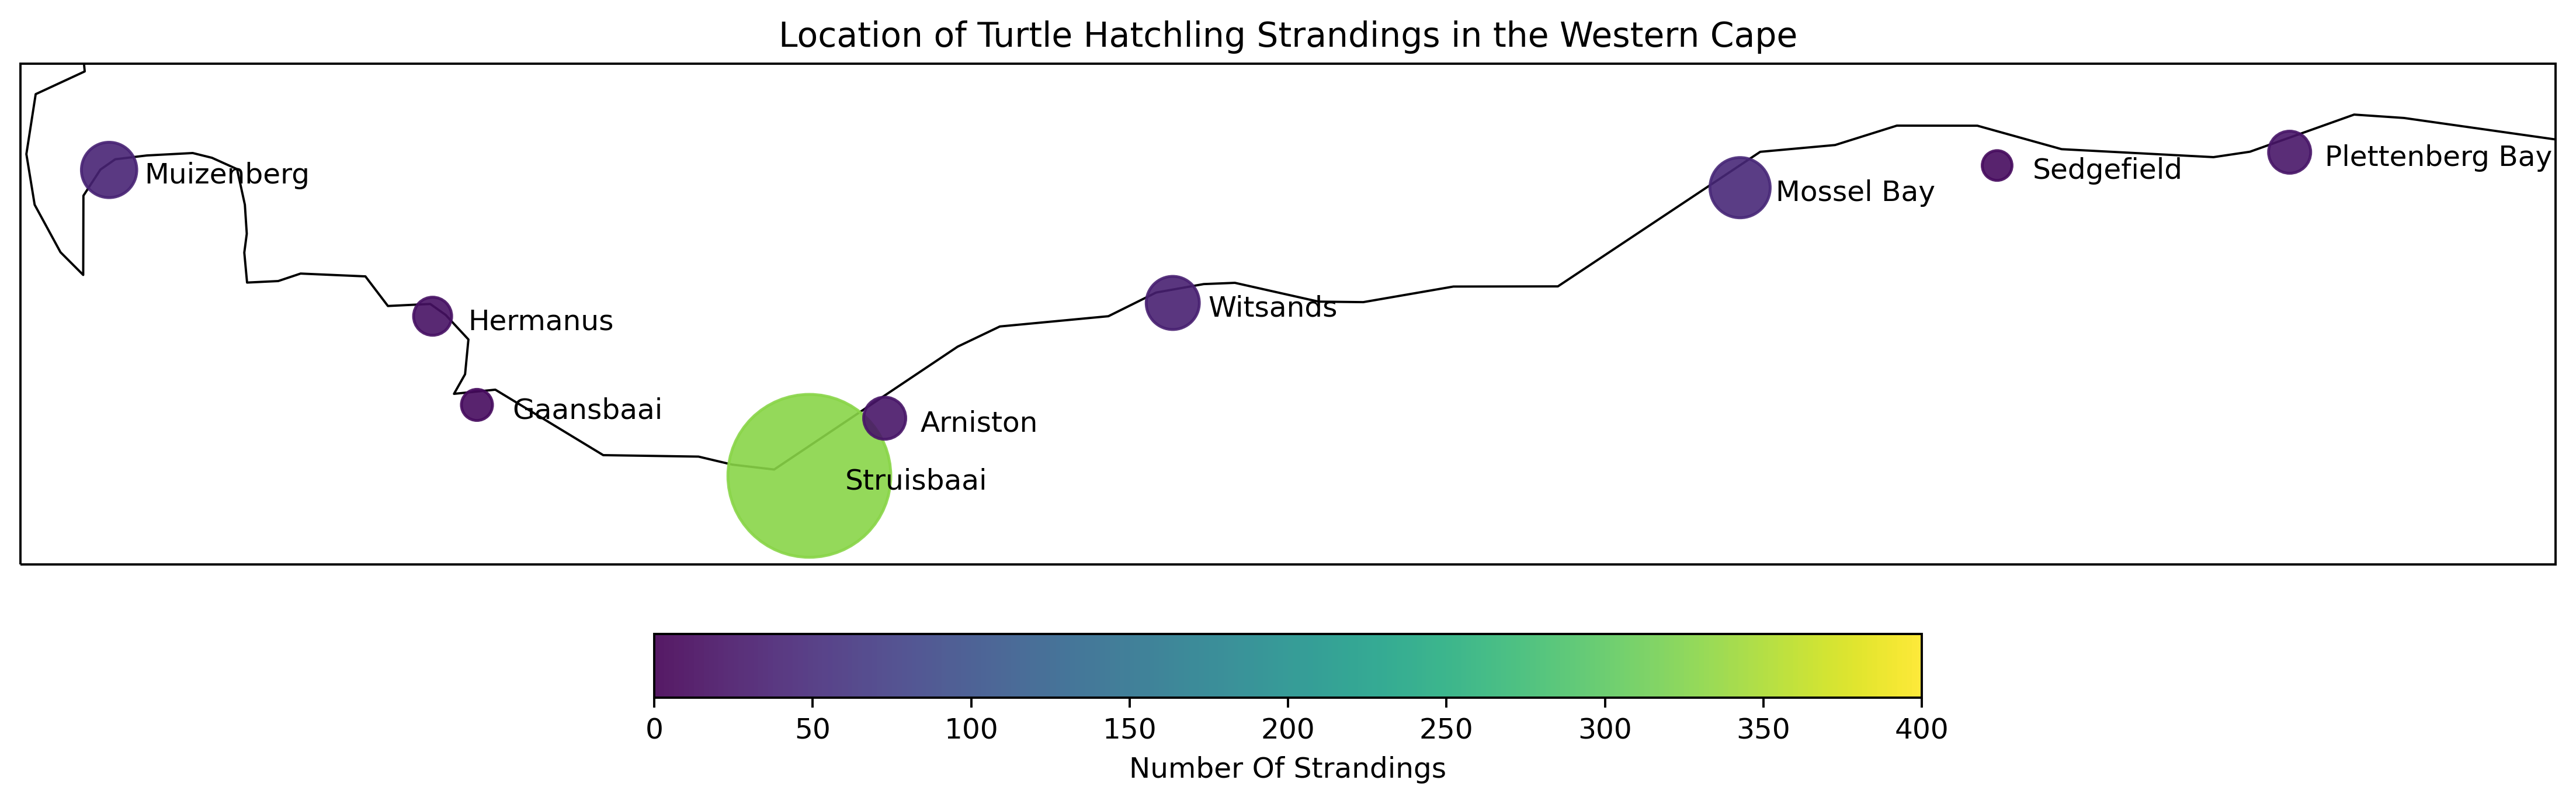

In [9]:
stranding_count = stranding_data.Location.value_counts() 

location = []
lats = []
lons = []
count = []
for index, n in stranding_count.items():
    location.append(index)
    lats.append(latlong_dict[index][0])
    lons.append(latlong_dict[index][1])
    count.append(n)


fig = plt.figure(figsize=(16,9), dpi = 350)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m', linewidth=0.8)

extent = (np.min(lons)-0.2,np.max(lons)+0.6, np.min(lats)-0.2,np.max(lats)+0.2)
ax.set_extent(extent)

scatterplot = ax.scatter(x = lons, y = lats, c=count, s = [x*10 for x in count], cmap = 'viridis', vmin = 0, vmax = 400, alpha=0.9,transform=ccrs.PlateCarree())

for loc,lat,lon in zip(location, lats, lons):
    ax.text(lon+0.08, lat-0.03, str(loc))

plt.colorbar(scatterplot, shrink = 0.5, orientation = 'horizontal', label = 'Number Of Strandings', pad=0.05)

plt.title('Location of Turtle Hatchling Strandings in the Western Cape')

plt.show()

Some years are seen to have vastly more strandings than other years, while strandings primarily occur in the months March, April and May

In [10]:
stranding_freq = stranding_data.groupby(stranding_data.Date).count()['Species'].rename('Standings')

stranding_freq.index = pd.to_datetime(stranding_freq.index)

def make_plot(Frequency):
    if Frequency == 'Weekly':
        return stranding_freq.groupby(stranding_freq.index.week).sum().hvplot.bar().opts(title = 'Weekly Strandings')
    elif Frequency == 'Monthly':
        return stranding_freq.groupby(stranding_freq.index.month).sum().hvplot.bar().opts(title = 'Monthly Strandings', xlabel = 'Month')
    else:
        return stranding_freq.groupby(stranding_freq.index.year).sum().hvplot.bar().opts(title = 'Annual Strandings')
        
        
widgets.interact(make_plot, Frequency = ['Weekly','Monthly','Annual']);

interactive(children=(Dropdown(description='Frequency', options=('Weekly', 'Monthly', 'Annual'), value='Weekly…

This is true across all stations with more than 10 strandings recorded

In [11]:
def make_plot2(Location, Frequency):
    location_data = stranding_data.loc[stranding_data['Location'] == str(Location)]
    location_freq = location_data.groupby(location_data.Date).count()['Species'].rename('Standings')
    location_freq.index = pd.to_datetime(location_freq.index)
    if Frequency == 'Weekly':
        return location_freq.groupby(location_freq.index.week).sum().reindex(np.linspace(1,52,52, dtype = int) , fill_value=0).hvplot.bar().opts(title = 'Weekly Strandings in '+str(Location))
    elif Frequency == 'Monthly':
        return location_freq.groupby(location_freq.index.month).sum().reindex(np.linspace(1,12,12, dtype = int) , fill_value=0).hvplot.bar().opts(title = 'Monthly Strandings in '+str(Location), xlabel = 'Month')
    elif Frequency == 'Daily':
        plt.scatter(x = location_freq.index, y = location_freq.values)
    else:
        return location_freq.groupby(location_freq.index.year).sum().hvplot.bar().opts(title = 'Annual Strandings in '+str(Location))
        
        
widgets.interact(make_plot2, Location=list(latlong_dict.keys()), Frequency = ['Weekly','Monthly','Annual','Daily']);

interactive(children=(Dropdown(description='Location', options=('Struisbaai', 'Mossel Bay', 'Muizenberg', 'Wit…

This is presumably due to the drift rate of the hatchling taking approximately 1 month to traverse the eastern coast of South Africa before arriving at the colder waters of the Western Cape, thus more hatchlings being situated off the coast and thus more likely for stranding events to occur

In [12]:
ds = xr.open_dataset('ERA5_reanalysis_East_Coast.nc').load()

In [13]:
# ensure lat lon corresponds to a point where sst is available
ocean_lons = ds.sst[0].dropna(dim = 'lat', how = 'any').dropna(dim = 'lon', how = 'any').lon.values
ocean_lats = ds.sst[0].dropna(dim = 'lat', how = 'any').dropna(dim = 'lon', how = 'any').lat.values

def return_nearest_ocean_latlon(latlon):
    ocean_lat = min(ocean_lats, key=lambda x:abs(x-latlon[0]))
    ocean_lon = min(ocean_lons, key=lambda x:abs(x-latlon[1]))
    return [ocean_lat,ocean_lon]


ocean_latlong_dict = {}
for index in latlong_dict:
    ocean_latlong_dict[index] = return_nearest_ocean_latlon(latlong_dict[index])

In [14]:
location = 'Struisbaai'

ds_loc = ds
ds_loc = ds_loc.sel(lat = ocean_latlong_dict[str(location)][0], method = 'nearest').sel(lon = ocean_latlong_dict[str(location)][1], method = 'nearest')
#ds_loc_daily = ds_loc.resample(time = 'D', closed = "right").mean().load()

location_data = stranding_data.loc[stranding_data['Location'] == str(location)]
location_freq = location_data.groupby(location_data.Date).count()['Species'].rename('Standings')
location_freq.index = pd.to_datetime(location_freq.index)

dates_sorted = list(location_freq.sort_values(ascending=False).index)

In [25]:
date = dates_sorted[0]
date_7 = date + timedelta(days = -7)
d = ds_loc.sel(time = slice(str(date_7), str(date)))
x = list(range(len(d.time.values)))
x.reverse()
x = [round(x_,2) for x_ in x]
ws = list(zip(x, d.ws.values))
ws_dir = list(zip(x, d.ws.values+3, [np.deg2rad(((dir_ - 90) % 360)) for dir_ in d.dir.values], d.ws.values))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
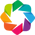

In [2]:
import numpy as np
import holoviews as hv
hv.extension('bokeh')

In [3]:
points = [(0.1*i, np.sin(0.1*i)) for i in range(100)]
hv.Curve(points)

:Curve   [x]   (y)

In [16]:
def wind_plot(stranding_date):
    date = stranding_date
    date_7 = date + timedelta(days = -7)
    d = ds_loc.sel(time = slice(str(date_7), str(date)))
    x = list(range(len(d.time.values)))
    x.reverse()
    x = [round(x_,2) for x_ in x]
    ws = list(zip(x, d.ws.values))
    ws_dir = list(zip(x, d.ws.values+3, [np.deg2rad(((dir_ - 90) % 360)) for dir_ in d.dir.values], d.ws.values))
    return hv.Overlay([hv.Curve(ws), hv.VectorField(ws_dir)]).opts(
        height=300, 
        width=600,
        xlabel='Hours Before Stranding', 
        ylabel='Wind Speed (knots)', 
        title='Wind Speed and Direction Over Previous 7 Days',
        invert_xaxis = True,
    )

In [17]:
def var_plot(variable, stranding_date):
    date = stranding_date
    date_7 = date + timedelta(days = -7)
    d = ds_loc.sel(time = slice(str(date_7), str(date)))
    x = list(range(len(d.time.values)))
    x.reverse()
    x = [round(x_,2) for x_ in x]
    if variable == 'sst':
        var = list(zip(x, d.sst.values))
    else:
        var = list(zip(x, d.t2m.values))
    return hv.Curve(var).opts(
        height=300, 
        width=600,
        xlabel='Hours Before Stranding', 
        ylabel='Temperature', 
        title='Wind Speed and Direction Over Previous 7 Days',
        invert_xaxis = True,
    )

In [18]:
def time_series_plot(variable, stranding_date):
    return (wind_plot(stranding_date) + var_plot(variable, stranding_date)).cols(1)

In [19]:
widgets.interact(time_series_plot, variable = ['sst','t2m'], stranding_date=dates_sorted);

interactive(children=(Dropdown(description='variable', options=('sst', 't2m'), value='sst'), Dropdown(descript…

In [19]:
ds_seasonal = ds_loc_daily.where(ds_loc.time.dt.season == 'MAM').dropna(dim='time', how = 'all')

strandings = list(set(stranding_data.loc[stranding_data['Location'] == 'Struisbaai'].Date))
strandings = pd.to_datetime(strandings)

march = [x for x in strandings if x.month == 3]
april = [x for x in strandings if x.month == 4]
may = [x for x in strandings if x.month == 5]
dates = march + april + may
dates.sort()

NameError: name 'ds_loc_daily' is not defined

In [ ]:
def make_kde_plot(lag):
    dates_1 = [date + timedelta(days = lag) for date in dates]
    ds_ = ds_loc_daily.sel(time = dates_1)
    def make_plot():
        fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(16,12))
        axs=axs.flatten()
        for i,var in enumerate(['sst','t2m','ws','dir','u10','v10']):
            sns.kdeplot(ds_seasonal[str(var)].values, ax = axs[i], label = 'Autumn')
            sns.kdeplot(ds_[str(var)].values, ax = axs[i],  label = 'Stranding Days')
            #axs[i].set_title(str(var))
            axs[i].legend()
        axs[0].set_xlabel('Sea Surface Temperature ($^\circ$C)')
        axs[1].set_xlabel('Air Temperature ($^\circ$C)')
        axs[2].set_xlabel('Wind Speed (knots)')
        axs[3].set_xlabel('Wind Direction')
        axs[4].set_xlabel('Eastward Wind Component (knots)')
        axs[5].set_xlabel('Northward Wind Component (knots)')
        fig.suptitle('Stranding day defined as '+str(lag)+' days from being rescued', fontsize=14, fontweight='bold')
    return(make_plot())

widgets.interact(make_kde_plot, lag=[-5,-4,-3,-2,-1,0]);